# Описание проекта

Подготовить прототип модели машинного для оптимизации производства, чтобы не запускать предприятие с убыточными характеристиками.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

## Оглавление

1. [Изучение общей информации и предобработка данных](#step_1)
2. [Анализ данных](#step_2)
    - 2.1. [Концентрация металлов на различных этапах очистки](#step_2_1)
    - 2.2. [Распределение размеров гранул сырья](#step_2_2)
    - 2.3. [Суммарная концентрация всех веществ на разных стадиях](#step_2_3)
3. [Обучение моделей](#step_3)
    - 3.1. [Функция расчета sMAPE](#step_3_1)
    - 3.2. [Подготовка признаков](#step_3_2)
    - 3.3. [Обучение и тест моделей](#step_3_3)
4. [Итоговый вывод](#step_4)

<a id="step_1"></a>
## 1. Изучение общей информации и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
pd.set_option('mode.chained_assignment', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")

Выведем все 3 DataFrame для изучения информации.

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
df_full.info()
df_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Как видно в данных имеются пропуски, в каждом столбце разное количество, так как по условию задачи сказано, что "Соседние по времени параметры часто похожи", это говорит о том, что можно использовать соседние параметры для подстановки в места пропусков.

Сначала напишем функцию для проверки корретности расчета показателя Recovery.

In [7]:
def recovery_new(C, F, T):
    """
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    """
    recovery = (C*(F-T)) / (F*(C-T)) * 100
    return recovery

df_train['rougher.output.recovery_new'] = recovery_new(df_train['rougher.output.concentrate_au'],
                                           df_train['rougher.input.feed_au'],
                                           df_train['rougher.output.tail_au'])
df_train[['rougher.output.recovery', 'rougher.output.recovery_new']]

,rougher.output.recovery,rougher.output.recovery_new
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


Как видно, показатель рассчитан корректно, так как исходные значения и рассчитанные нами равны. Но может быть небольшая погрешность, надо это проверить с помощью показателя `mae`.

In [8]:
mae = (df_train['rougher.output.recovery'] - df_train['rougher.output.recovery_new']).mean()
mae

1.168115944996525e-16

Как видно показатель стремится к нулю, следовательно мы рассчитали правильно новые значения.

Как не сложно заметить в тествых данных отстутствуют столбцы, которые относятся к целевому признаку, то есть то, что должна рассчитывать наша модель, так же отсутствует ряд колонок, которые получаются при последующих этапах обработки. Добавлять в test отсутствующие колонки не нужно.

Теперь перейдём к пропускам, воспользуемся тем, что заметили вначале, что "Соседние по времени параметры часто похожи", будем использовать `method='ffill'`.

In [9]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

<a id="step_2"></a>
## 2. Анализ данных

Переёдем к анализу основных металлов присутствующих в процессах.

<a id="step_2_1"></a>
## 2.1. Концентрация металлов на различных этапах очистки

Чтобы понять, насколько необходим процесс очистки, рассмотрим как меняется концентрация металлов (Ag, Au, Pb, Sol) в зависимости от этапа обработки:

- Au - золото;
- Ag - серебро;
- Pb - свинец;
- Sol - твердые вещества.

- Вещество до воздействия обработки.

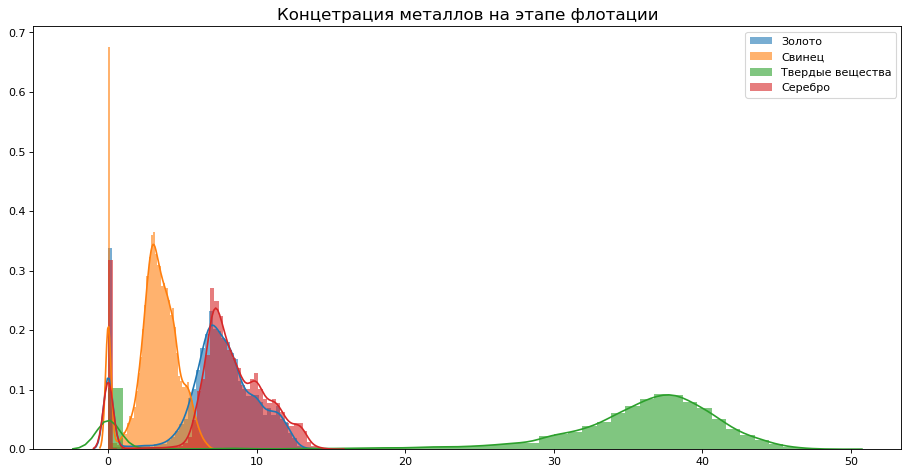

In [10]:
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df_train['rougher.input.feed_au'], hist_kws={'alpha':.6}, label='Золото')
sns.distplot(df_train['rougher.input.feed_pb'], hist_kws={'alpha':.6}, label='Свинец')
sns.distplot(df_train['rougher.input.feed_sol'], hist_kws={'alpha':.6}, label='Твердые вещества')
sns.distplot(df_train['rougher.input.feed_ag'], hist_kws={'alpha':.6}, label='Серебро')

plt.legend()
plt.title('Концетрация металлов на этапе флотации', fontsize=15)
plt.xlabel('')
plt.show()

- Первый этап rougher — флотация. 

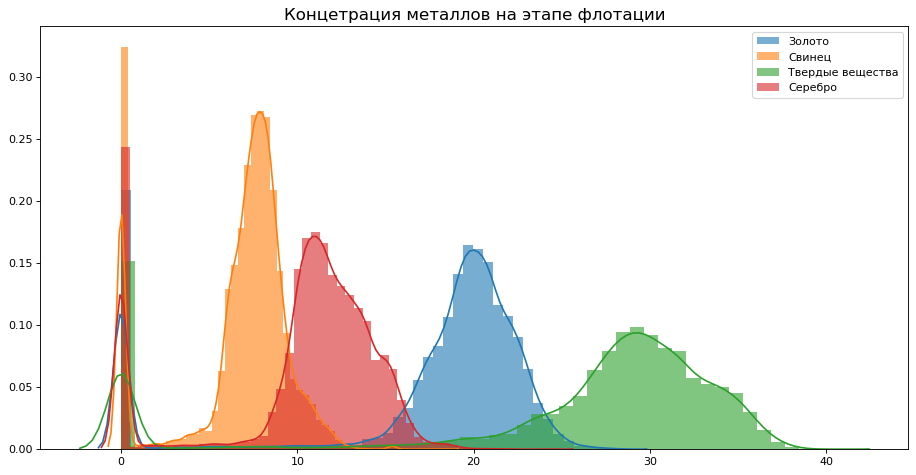

In [11]:
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df_train['rougher.output.concentrate_au'], hist_kws={'alpha':.6}, label='Золото')
sns.distplot(df_train['rougher.output.concentrate_pb'], hist_kws={'alpha':.6}, label='Свинец')
sns.distplot(df_train['rougher.output.concentrate_sol'], hist_kws={'alpha':.6}, label='Твердые вещества')
sns.distplot(df_train['rougher.output.concentrate_ag'], hist_kws={'alpha':.6}, label='Серебро')

plt.legend()
plt.title('Концетрация металлов на этапе флотации', fontsize=15)
plt.xlabel('')
plt.show()

- Второй этап Primary_cleaner — первичная очистка.

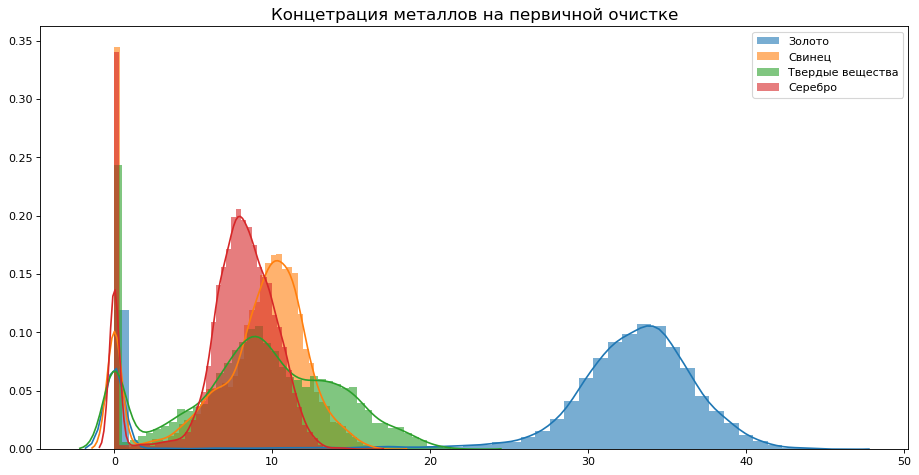

In [12]:
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df_train['primary_cleaner.output.concentrate_au'], hist_kws={'alpha':.6}, label='Золото')
sns.distplot(df_train['primary_cleaner.output.concentrate_pb'], hist_kws={'alpha':.6}, label='Свинец')
sns.distplot(df_train['primary_cleaner.output.concentrate_sol'], hist_kws={'alpha':.6}, label='Твердые вещества')
sns.distplot(df_train['primary_cleaner.output.concentrate_ag'], hist_kws={'alpha':.6}, label='Серебро')

plt.legend()
plt.title('Концетрация металлов на первичной очистке', fontsize=15)
plt.xlabel('')
plt.legend()
plt.show()

- Третий и четвертый этапы Secondary_cleaner — вторичная очистка и final — финальные характеристики.

Объединим эти этапы вместе, так как после вторичной очистки остаются только "хвосты" и финальные характеристики.

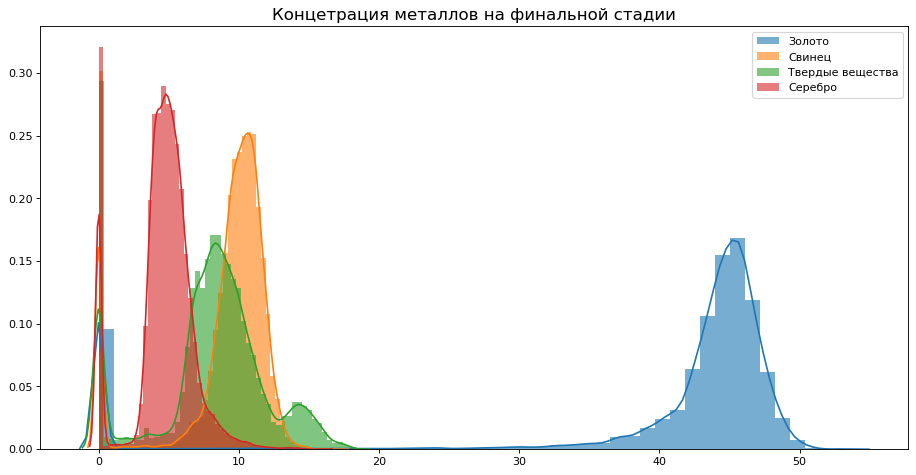

In [13]:
# при постройке будем использовать данные только финального этапа
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df_train['final.output.concentrate_au'], hist_kws={'alpha':.6}, label='Золото')
sns.distplot(df_train['final.output.concentrate_pb'], hist_kws={'alpha':.6}, label='Свинец')
sns.distplot(df_train['final.output.concentrate_sol'], hist_kws={'alpha':.6}, label='Твердые вещества')
sns.distplot(df_train['final.output.concentrate_ag'], hist_kws={'alpha':.6}, label='Серебро')

plt.legend()
plt.title('Концетрация металлов на финальной стадии', fontsize=15)
plt.xlabel('')
plt.legend()
plt.show()

Как видно, к финальной стадии соотношение металлов изменяется очень отчетливо.

Для нас самый важный металл будет золото, так как весь процесс построен, чтобы концетрация к финальному этапу была максимальна. 

На первом этапе концетрация золота имеет долю в 28,9% в общей массе. На первичной очистке показатель увеличивается почти в 2 раза и составляет уже 53,9%. На финальной стадии показатель уже равен 64,2%.

Получается при очитски металлов, концетрация золота повышается более чем в 2 раза.

<a id="step_2_2"></a>
## 2.2. Распределение размеров гранул сырья

Посмотрим, как распределяются гранулы на train и test выборках.

Смотреть расспределения будем на стадии флотации и первичной очистке.

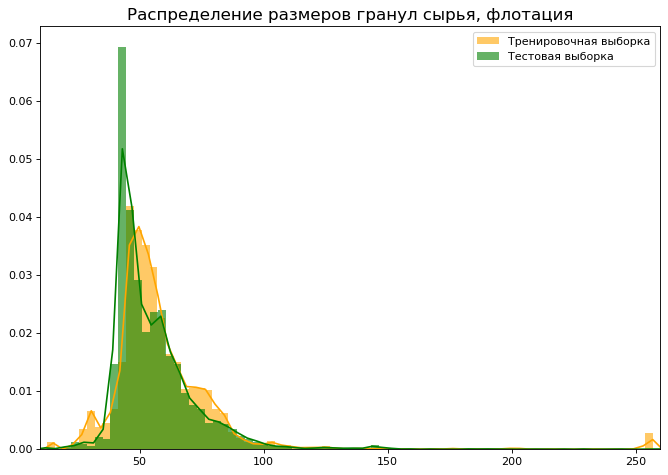

In [14]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df_train['rougher.input.feed_size'], color='orange', label='Тренировочная выборка', 
             hist_kws={'alpha':.6}, kde_kws={'linewidth':1.5}, bins=150)
sns.distplot(df_test['rougher.input.feed_size'], color='g', label='Тестовая выборка', 
             hist_kws={'alpha':.6}, kde_kws={'linewidth':1.5}, bins=150)
plt.xlim(10, 260)
plt.xlabel('')
plt.title('Распределение размеров гранул сырья, флотация', fontsize=15)
plt.legend()
plt.show()

In [15]:
print('Тренировочная выборка')
print(df_train['rougher.input.feed_size'].describe())
print('')
print('Тестовая выборка')
print(df_test['rougher.input.feed_size'].describe())

Тренировочная выборка
count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Тестовая выборка
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


Как видно на этапе флотации гранулы имеют разное распределение на тренировочной и тестовой выборках, что видно и на графике и на показателях метода `describe`. Посмотрим далее, как гранулы распределены на первичной очистке.

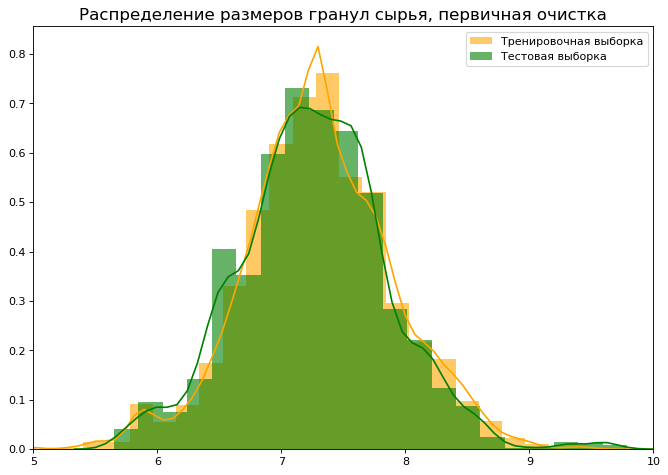

In [16]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df_train['primary_cleaner.input.feed_size'], color='orange', label='Тренировочная выборка', 
             hist_kws={'alpha':.6}, kde_kws={'linewidth':1.5})
sns.distplot(df_test['primary_cleaner.input.feed_size'], color='g', label='Тестовая выборка', 
             hist_kws={'alpha':.6}, kde_kws={'linewidth':1.5})
plt.xlim(5, 10)
plt.xlabel('')
plt.title('Распределение размеров гранул сырья, первичная очистка', fontsize=15)
plt.legend()
plt.show()

In [17]:
print('Тренировочная выборка')
print(df_train['primary_cleaner.input.feed_size'].describe())
print('')
print('Тестовая выборка')
print(df_test['primary_cleaner.input.feed_size'].describe())

Тренировочная выборка
count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

Тестовая выборка
count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


На данном этапе распределение уже имеет нормальный вид и графики имеют схожий вид. Также среднее, среднеквадратичное отклонение и медиана имеют очень близкие значения, что говорит о схожести распределений.

<a id="step_2_3"></a>
## 2.3. Суммарная концентрация всех веществ на разных стадиях

Посмотрим на суммарное распределение вещест на разных стадиях.

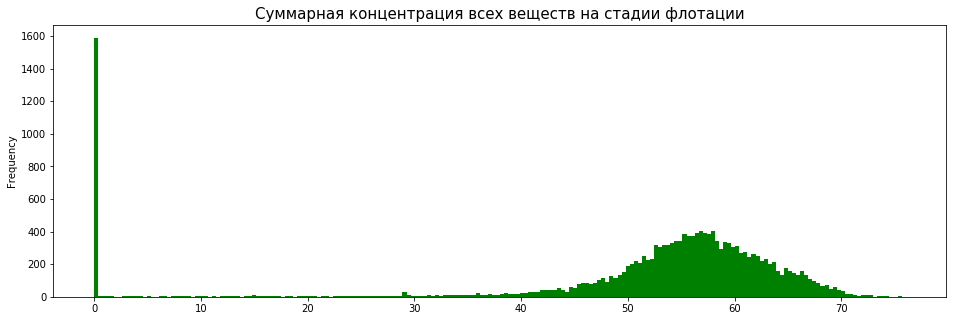

In [18]:
rougher_sum_concentrate_train = (df_train['rougher.input.feed_ag'] 
                                 + df_train['rougher.input.feed_pb'] 
                                 + df_train['rougher.input.feed_sol'] 
                                 + df_train['rougher.input.feed_au'])
rougher_sum_concentrate_train.plot(kind='hist', figsize=(16, 5), bins=200, color='g')
plt.title('Суммарная концентрация всех веществ на стадии флотации', fontsize=15)
plt.show()

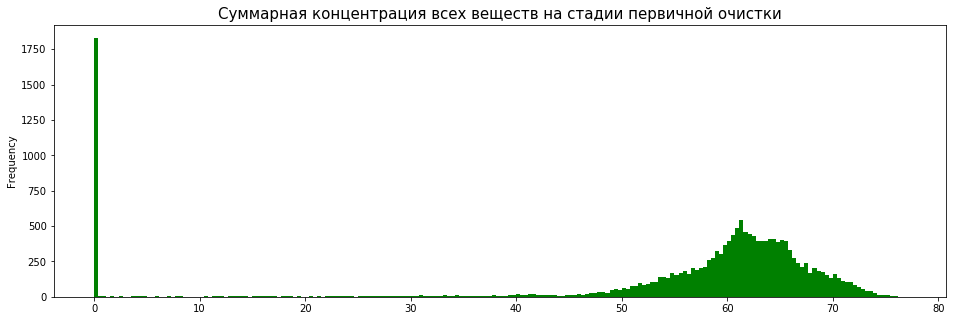

In [19]:
primary_sum_concentrate_train = (df_train['primary_cleaner.output.concentrate_ag'] 
                            + df_train['primary_cleaner.output.concentrate_pb']
                            + df_train['primary_cleaner.output.concentrate_sol'] 
                            + df_train['primary_cleaner.output.concentrate_au'])
primary_sum_concentrate_train.plot(kind='hist', figsize=(16, 5), bins=200, color='g')
plt.title('Суммарная концентрация всех веществ на стадии первичной очистки', fontsize=15)
plt.show()

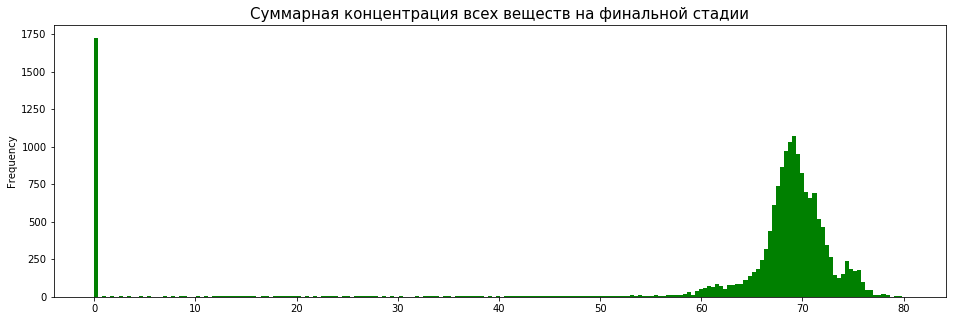

In [20]:
final_sum_concentrate_train = (df_train['final.output.concentrate_ag'] 
                            + df_train['final.output.concentrate_pb']
                            + df_train['final.output.concentrate_sol'] 
                            + df_train['final.output.concentrate_au'])
final_sum_concentrate_train.plot(kind='hist', figsize=(16, 5), bins=200, color='g')
plt.title('Суммарная концентрация всех веществ на финальной стадии', fontsize=15)
plt.show()

Как видно, есть суммарная концентрация всех веществ равная нулю, следует что веществ тогда просто нет, раз значение ноль, вероятно что ошибка в данных, так как вещества должны быть, даже в малом количестве, поэтому не будем использовать эти строки.

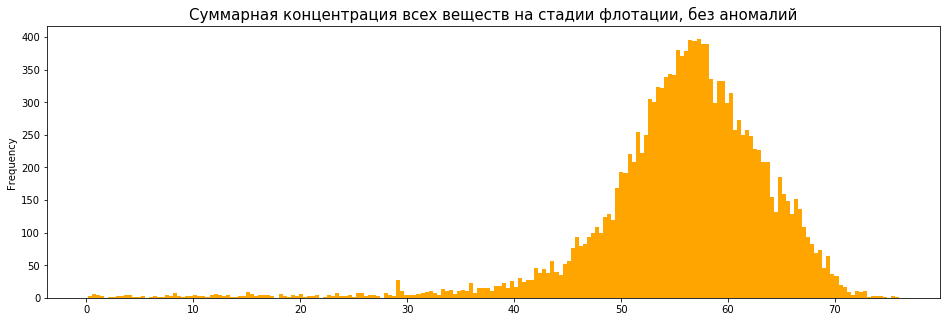

In [21]:
df_train = df_train.query('@rougher_sum_concentrate_train > 0.05')
rougher_sum_concentrate_train_new = (df_train['rougher.input.feed_ag'] 
                         + df_train['rougher.input.feed_pb'] 
                         + df_train['rougher.input.feed_sol'] 
                         + df_train['rougher.input.feed_au'])
rougher_sum_concentrate_train_new.plot(kind='hist', figsize=(16, 5), bins=200, color='orange')
plt.title('Суммарная концентрация всех веществ на стадии флотации, без аномалий', fontsize=15)
plt.show()

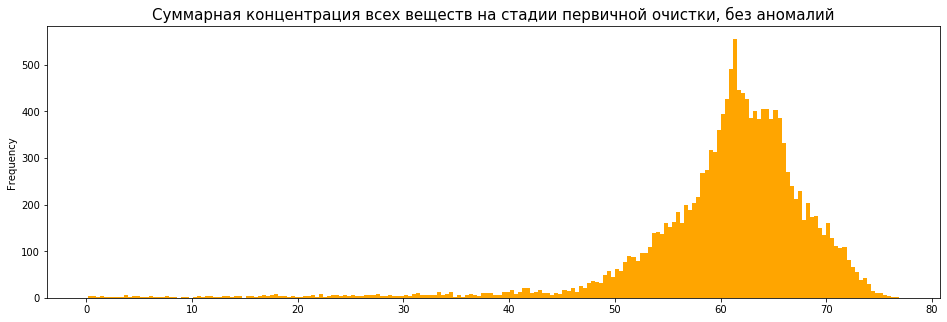

In [22]:
df_train = df_train.query('@primary_sum_concentrate_train > 0.05')
primary_sum_concentrate_train_new = (df_train['primary_cleaner.output.concentrate_ag'] 
                                + df_train['primary_cleaner.output.concentrate_pb']
                                + df_train['primary_cleaner.output.concentrate_sol'] 
                                + df_train['primary_cleaner.output.concentrate_au'])
primary_sum_concentrate_train_new.plot(kind='hist', figsize=(16, 5), bins=200, color='orange')
plt.title('Суммарная концентрация всех веществ на стадии первичной очистки, без аномалий', fontsize=15)
plt.show()

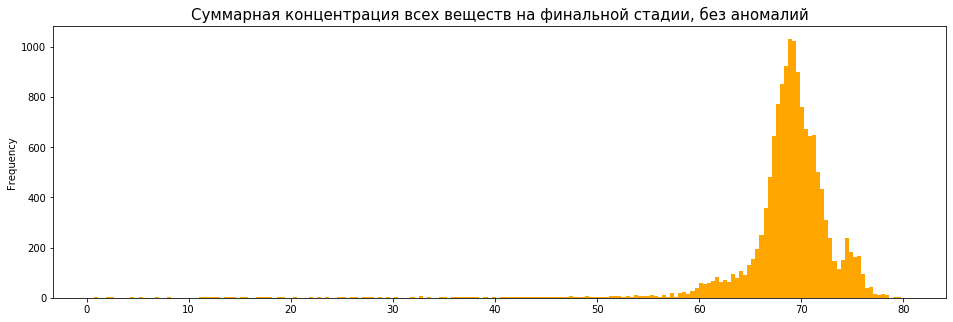

In [23]:
df_train = df_train.query('@final_sum_concentrate_train > 0.05')
final_sum_concentrate_train_new = (df_train['final.output.concentrate_ag'] 
                            + df_train['final.output.concentrate_pb']
                            + df_train['final.output.concentrate_sol'] 
                            + df_train['final.output.concentrate_au'])
final_sum_concentrate_train_new.plot(kind='hist', figsize=(16, 5), bins=200, color='orange')
plt.title('Суммарная концентрация всех веществ на финальной стадии, без аномалий', fontsize=15)
plt.show()

Теперь распределение имеет более правильный вид, с которым можно работать в дальнейшем.

Так же удалим такие строчки и из выборки test.

In [24]:
rougher_sum_concentrate_test = (df_test['rougher.input.feed_ag'] 
                         + df_test['rougher.input.feed_pb'] 
                         + df_test['rougher.input.feed_sol'] 
                         + df_test['rougher.input.feed_au'])
df_test = df_test.query('@rougher_sum_concentrate_test > 0.05')

## Вывод

Проведя анализ мы выяснили:
- консентрация золота к финальному этапу растет, а других металлов падает, что логично, ради этого задумывался весь процесс;
- распределение гранул имеет распределение Пуасона на стадии флотации, и нормальное распределение на финальной стадии;
- есть данные, которые являются не логичными, сумма металлов равна нулю, мы их убрали.

<a id="step_3"></a>
## 3. Обучение моделей

<a id="step_3_1"></a>
## 3.1. Функция расчета sMAPE

Начнем данный этап с написания функции для расчета sMAPE.

![image.png](https://pictures.s3.yandex.net/resources/smape_1576239058.jpg) 

                                                            Обозначения:
![image.png](https://pictures.s3.yandex.net/resources/y1_1576238832.jpg)
        - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
![image.png](https://pictures.s3.yandex.net/resources/yi_1_1576238835.jpg)
        - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
![image.png](https://pictures.s3.yandex.net/resources/N_1_1576238819.jpg)
        - Количество объектов в выборке.
![image.png](https://pictures.s3.yandex.net/resources/I_1576238817.jpg)
        - Суммирование по всем объектам выборки (i меняется от 1 до N).

In [25]:
def smape(y_target, y_pred):
    smape = (1/len(y_target)) * ((abs(y_target - y_pred))/((abs(y_target) + abs(y_pred))/2)).sum() * 100
    return smape

Теперь напишем функцию расчета итоговое sMAPE.

![image](https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg)

In [26]:
def final_smape(smape_rougher, smape_final):
    final_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape

<a id="step_3_2"></a>
## 3.2. Подготовка признаков

Подготовим признаки и целевой признак для обучения и проверки моделей.

In [27]:
features_train = df_train[df_test.columns].drop('date', axis=1)
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]
target_train_grid = df_train['final.output.recovery']

# добавим из df_full столбцы 'rougher.output.recovery', 'final.output.recovery',
# чтобы выделить целевые признаки
df_test_new = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

features_test = df_test_new.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = df_test_new[['rougher.output.recovery', 'final.output.recovery']]
target_test_1 = df_test_new['rougher.output.recovery']
target_test_2 = df_test_new['final.output.recovery']

<a id="step_3_3"></a>
## 3.3. Обучение и тест моделей

Будем использовать для оценки 3 модели: линейную регрессию, случайный лес и дерево решений. И посмотрим, какая модель покажет лучший результат.

In [28]:
# DataFrame для внесения результатов моделей
data_result = pd.DataFrame(columns=['Model', 'sMAPE_rougher', 'sMAPE_final', 'Итоговое_sMAPE'])

In [29]:
# Функция для внесения результатов в DataFrame
def results(data, model, rougher, final):
    data = data.append({'Model':model,
                    'sMAPE_rougher':'{:.2f}'.format(rougher),
                    'sMAPE_final':'{:.2f}'.format(final),
                    'Итоговое_sMAPE':'{:.2f}'.format(final_smape(rougher, final))}, 
                   ignore_index=True)
    return data

Обучим модели с методом кросс валидации и без данного метода.

In [30]:
score_smape = make_scorer(smape) 
model_lin_val = LinearRegression()
smape_rougher_lin_val = cross_val_score(model_lin_val, features_test, target_test_1, cv=5, scoring=score_smape).mean()
smape_final_lin_val = cross_val_score(model_lin_val, features_test, target_test_2, cv=5, scoring=score_smape).mean()

In [31]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
pred_model_1 = model_1.predict(features_test)

pred_model_1 = np.array(pred_model_1)
target_test = np.array(target_test)

smape_rougher_1 = smape(target_test[0,:], pred_model_1[0,:])
smape_final_1 = smape(target_test[:,0], pred_model_1[:,0])

In [32]:
#score_smape_1 = make_scorer(smape, greater_is_better=False)
#model_2_test = RandomForestRegressor(random_state=123)
#parametrs = { 'n_estimators': range (10, 51, 10),
#              'max_depth': range (2,13)}
#grid = GridSearchCV(model_2_test, parametrs, scoring=score_smape_1)
#grid.fit(features_train, target_train_grid)
#grid.best_params_

Значения параметров полученные после GridSearchCV 

{'max_depth': 2, 'n_estimators': 50}

In [33]:
model_forest_val = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=123)
smape_rougher_forest_val = cross_val_score(model_forest_val, features_test, target_test_1, cv=5, scoring=score_smape).mean()
smape_final_forest_val = cross_val_score(model_forest_val, features_test, target_test_2, cv=5, scoring=score_smape).mean()

In [34]:
model_2 = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=123)
model_2.fit(features_train, target_train)
pred_model_2 = model_2.predict(features_test)

pred_model_2 = np.array(pred_model_2)
target_test = np.array(target_test)

smape_rougher_2 = smape(target_test[0,:], pred_model_2[0,:])
smape_final_2 = smape(target_test[:,0], pred_model_2[:,0])

In [35]:
model_tree_val = DecisionTreeRegressor(max_depth=2, random_state=123)
smape_rougher_test_tree = cross_val_score(model_tree_val, features_test, target_test_1, cv=5, scoring=score_smape).mean()
smape_final_test_tree = cross_val_score(model_tree_val, features_test, target_test_2, cv=5, scoring=score_smape).mean()

In [36]:
model_3 = DecisionTreeRegressor(max_depth=2, random_state=123)
model_3.fit(features_train, target_train)
pred_model_3 = model_3.predict(features_test)

pred_model_3 = np.array(pred_model_3)
target_test = np.array(target_test)

smape_rougher_3 = smape(target_test[0,:], pred_model_3[0,:])
smape_final_3 = smape(target_test[:,0], pred_model_3[:,0])

Так же сравним наши модели с DummyRegressor, насколько хорошо обучены они.

In [37]:
dummy_clf_val = DummyRegressor()
smape_rougher_test_clf = cross_val_score(dummy_clf_val, features_test, target_test_1, cv=5, scoring=score_smape).mean()
smape_final_test_clf = cross_val_score(dummy_clf_val, features_test, target_test_2, cv=5, scoring=score_smape).mean()

In [38]:
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
pred_dummy_clf = dummy_clf.predict(features_test)

pred_dummy_clf = np.array(pred_dummy_clf)
target_test = np.array(target_test)

smape_rougher_clf = smape(target_test[0,:], pred_dummy_clf[0,:])
smape_final_clf = smape(target_test[:,0], pred_dummy_clf[:,0])

In [39]:
data_result = results(data_result, 'LinearRegression кросс валидация', smape_rougher_lin_val, smape_final_lin_val)
data_result = results(data_result, 'LinearRegression', smape_rougher_1, smape_final_1)
data_result = results(data_result, 'RandomForestRegressor кросс валидация', smape_rougher_forest_val, smape_final_forest_val)
data_result = results(data_result, 'RandomForestRegressor', smape_rougher_2, smape_final_2)
data_result = results(data_result, 'DecisionTreeRegressor кросс валидация', smape_rougher_test_tree, smape_final_test_tree)
data_result = results(data_result, 'DecisionTreeRegressor', smape_rougher_3, smape_final_3)
data_result = results(data_result, 'DummyRegressor кросс валидация', smape_rougher_test_clf, smape_final_test_clf)
data_result = results(data_result, 'DummyRegressor', smape_rougher_clf, smape_final_clf)

In [40]:
data_result['Итоговое_sMAPE'] = data_result['Итоговое_sMAPE'].astype(float)
data_result.sort_values('Итоговое_sMAPE')

,Model,sMAPE_rougher,sMAPE_final,Итоговое_sMAPE
5,DecisionTreeRegressor,2.31,9.01,7.34
3,RandomForestRegressor,3.92,9.49,8.09
1,LinearRegression,1.39,11.32,8.83
7,DummyRegressor,7.01,11.11,10.09
2,RandomForestRegressor кросс валидация,11.19,10.55,10.71
6,DummyRegressor кросс валидация,9.75,11.04,10.72
4,DecisionTreeRegressor кросс валидация,10.78,11.06,10.99
0,LinearRegression кросс валидация,13.44,12.11,12.45


DecisionTreeRegressor показало самый хороший результат среди 3 моделей при стандартном обучение, на кросс валидации же случайный лес показал лучшие параметры. Дерево решений показало результат лучше чем DummyRegressor, случайный лес на 0.01 опередил тоже, а линейная регрессия не смогла обойти DummyRegressor.

<a id="step_4"></a>
## 4. Итоговый вывод

В нашем распоряжении были 3 набора данных: train, test, full. Train и test являются частью full.

При изучении данных было обнаружено много пропусков, мы их заполнили методом `method='ffill'`, так как в условии говорится, что "Соседние по времени параметры часто похожи", это даёт нам то, что мы можем подставить соседние значения.

Проведя анализ данных мы получили следующие результаты:
- консентрация золота к финальному этапу растет, а других металлов падает, что логично, ради этого задумывался весь процесс;
- распределение гранул имеет распределение Пуасона на стадии флотации, и нормальное распределение на финальной стадии;
- есть данные, которые являются не логичными, сумма металлов равна нулю, мы их убрали.

На финальном этапе мы построили 2 функции для рассчетов показателей. 

Провели обучение 3-ех моделей, с помощью стандартного обучения и метода кросс валидации, также сравнили модели с DummyRegressor. По итогу сравнения дерево решений показало самый хороший результат на стандартном обучение, а на кросс валидации случайный лес.